In [1]:
# Install the dependencies.
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 10.5 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.7/591.7 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 44.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re,string
from underthesea import word_tokenize
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from gensim.models import KeyedVectors
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from timeit import default_timer as timer
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "../input/englishvietnamese-translation/"
en_sents = open(data_dir + 'en_sents', "r").read().splitlines()
vi_sents = open(data_dir + 'vi_sents', "r").read().splitlines()
raw_data = {
        "en": [line for line in en_sents[:170000]], # Only take first 170000 lines
        "vi": [line for line in vi_sents[:170000]],
    }
df = pd.DataFrame(raw_data, columns=["en", "vi"])
print(len(en_sents))
df.head()

254090


,en,vi
0,Please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,Be quiet for a moment.,im lặng một lát
2,Read this,đọc này
3,Tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,Friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


This dataset provides a set of 254,090 tuples containing an English source sentence, its Vietnamese human translation and we take 170000 set for training and evaluation

## Data Preprocessing

In [4]:
df.isna().sum()

en    0
vi    0
dtype: int64

In [5]:
def preprocessing(df): 
  df["en"] = df["en"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
  df["vi"] = df["vi"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation)))  
  df["en"] = df["en"].apply(lambda ele: ele.lower()) # convert text to lowercase
  df["vi"] = df["vi"].apply(lambda ele: ele.lower())
  df["en"] = df["en"].apply(lambda ele: ele.strip()) 
  df["vi"] = df["vi"].apply(lambda ele: ele.strip()) 
  df["en"] = df["en"].apply(lambda ele: re.sub("\s+", " ", ele)) 
  df["vi"] = df["vi"].apply(lambda ele: re.sub("\s+", " ", ele))
    
  return df

df = preprocessing(df)
df.head()

,en,vi
0,please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,be quiet for a moment,im lặng một lát
2,read this,đọc này
3,tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


Tokenzing for english which is source language by tokenizer of basic english and vietnamese which is target language by Underthesea library

In [6]:
# Create source and target language tokenizer.
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'vi'

# Place-holders
token_transform = {}
vocab_transform = {}

# Tokenize for vietnames by underthesea
def vi_tokenizer(sentence):
    tokens = word_tokenize(sentence)
    return tokens

token_transform[SRC_LANGUAGE] = get_tokenizer('basic_english')
token_transform[TGT_LANGUAGE] = get_tokenizer(vi_tokenizer)

# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:    
    for index,data_sample in data_iter:
        yield token_transform[language](data_sample[language])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = df.iterrows()
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

## Model Defination

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Check whether running on gpu or cpu

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size) 
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)
   
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Define the parameters of the model, instantiate the same and the loss function which is the cross-entropy loss and the optmizer used for training is Adam with β1 = 0.9, β2 = 0.98 and epsilon = 1e−9.

In [9]:
torch.manual_seed(0)
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8 # embed_dim must be divisible by num_heads
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROP_OUT = 0.1

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM,DROP_OUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Define collate function that convert batch of raw strings into batch tensors that can be fed directly into model.

In [10]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor



     
# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Split data to train and test set

In [11]:
# Split data to tran test set
split_ratio = 0.9
split = round(df.shape[0]* split_ratio)
train = df.iloc[:split]
train_ds = list(zip(train['en'],train['vi']))
valid = df.iloc[split:]
val_ds = list(zip(valid['en'],valid['vi']))

Define training and evaluation loop that will be called for each epoch with Gradient accumulation which is a technique where you can train on bigger batch sizes than your machine would normally be able to fit into memory. This is done by accumulating gradients over several batches, and only stepping the optimizer after a certain number of batches have been performed.

In [12]:
from torch.utils.data import DataLoader

accumulation_steps = 5

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    val_los = 0
    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    optimizer.zero_grad() 
    for i, (src, tgt) in enumerate(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)   
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps # Normalize our loss (if averaged)
        loss.backward()
        
        if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
            optimizer.step() # Now we can do an optimizer step
            optimizer.zero_grad() # Reset gradients tensor  

        losses += loss.item()

    return losses / len(train_dataloader)

def evaluate(model):
    model.eval()
    losses = 0

    #val_iter = valid.iterrows()
    val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps # Normalize our loss (if averaged)
        losses += loss.item()

    return losses / len(val_dataloader)

Define an early stopping function to avoid the model from overfit

In [13]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

Training model

In [14]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)
NUM_EPOCHS = 30
history = {
        "loss": [], 
        "val_los": []
        }

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    history['loss'].append(train_loss)
    history['val_los'].append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    # Early Stopping
    early_stopping(train_loss, val_loss)
    if early_stopping.early_stop:
        print("We are at epoch:", epoch)
        break

Epoch: 1, Train loss: 0.940, Val loss: 0.627, Epoch time = 176.732s
Epoch: 2, Train loss: 0.536, Val loss: 0.400, Epoch time = 174.989s
Epoch: 3, Train loss: 0.379, Val loss: 0.308, Epoch time = 174.382s
Epoch: 4, Train loss: 0.297, Val loss: 0.256, Epoch time = 174.051s
Epoch: 5, Train loss: 0.245, Val loss: 0.223, Epoch time = 174.168s
Epoch: 6, Train loss: 0.210, Val loss: 0.202, Epoch time = 175.297s
Epoch: 7, Train loss: 0.184, Val loss: 0.186, Epoch time = 174.193s
Epoch: 8, Train loss: 0.164, Val loss: 0.177, Epoch time = 174.420s
Epoch: 9, Train loss: 0.147, Val loss: 0.166, Epoch time = 174.503s
Epoch: 10, Train loss: 0.134, Val loss: 0.160, Epoch time = 174.014s
Epoch: 11, Train loss: 0.122, Val loss: 0.155, Epoch time = 174.015s
Epoch: 12, Train loss: 0.112, Val loss: 0.151, Epoch time = 177.406s
Epoch: 13, Train loss: 0.104, Val loss: 0.148, Epoch time = 175.501s
Epoch: 14, Train loss: 0.096, Val loss: 0.145, Epoch time = 175.107s
Epoch: 15, Train loss: 0.090, Val loss: 0.1

Traning and Validate plotting

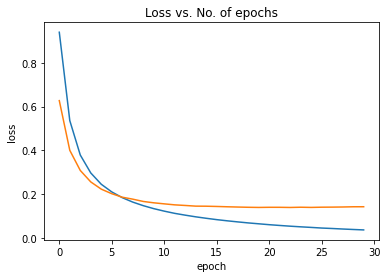

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history['loss'], label = "loss")
plt.plot(history['val_los'], label = "Val loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

**Inference**

In [16]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [22]:
# Saving model
torch.save(transformer.state_dict(), "viEn_transformer.pth")

Testing model by randomly take 10 samples from the rest of the dataset

In [18]:
from random import randint
rand = [randint(170000,200000) for i in range(10)]
test_set = [
        [en_sents[i] for i in rand],
        [vi_sents[i] for i in rand]]
    
for i in range(len(test_set[0])):
    print('Input English sentence:', test_set[0][i])
    print('Actual Vietnamese Translation:', test_set[1][i])
    print('Predicted Vietnamese Translation:', translate(transformer, test_set[0][i]))
    print("\n")

Input English sentence: He tried it again, only to fail
Actual Vietnamese Translation: anh thử lại lần nữa, chỉ để thất bại
Predicted Vietnamese Translation:  anh ấy đã thử nó một lần nữa chỉ để thất bại 


Input English sentence: This stone weighs five tons.
Actual Vietnamese Translation: hòn đá này nặng năm tấn.
Predicted Vietnamese Translation:  hòn đá này nặng năm tấn sách 


Input English sentence: I wanna get out of here!
Actual Vietnamese Translation: tôi muốn ra khỏi đây
Predicted Vietnamese Translation:  tôi muốn ra khỏi đây ngay 


Input English sentence: That stove smokes too much
Actual Vietnamese Translation: cái bếp đó hút quá nhiều
Predicted Vietnamese Translation:  bếp đó hút thuốc quá nhiều 


Input English sentence: Compared to those around him, he looked really happy.
Actual Vietnamese Translation: so với những người xung quanh, anh ấy trông thực sự hạnh phúc.
Predicted Vietnamese Translation:  so với những người xung quanh trông anh ta thực sự rất hạnh phúc khi thể 

With a little effort we can deploy our own training model via API with fastAPI. Check out my demo by the link below

https://youtu.be/OOJfZm6OpvI

**References**

https://pytorch.org/tutorials/beginner/translation_transformer.html